# 2. Using sklearn with CapyMOA

In this tutorial we demonstrate how someone can directly use scikit-learn learners in CapyMOA.
* The primary requirement for a scikit-learn learner to be used is that it implements `partial_fit()`

---

*More information about CapyMOA can be found in* https://www.capymoa.org

**last update on 03/05/2024**

## 1. Using raw sklearn objects

* This example shows a model from scikit-learn can be used with our ```Instance``` representation in a simple **test-then-train loop**
* In this case, we need to adapt data to accommodate what the sklearn expects

In [1]:
# This cell is hidden on capymoa.org. See docs/contributing/docs.rst
from util.nbmock import mock_datasets, is_nb_fast

if is_nb_fast():
    mock_datasets()

In [2]:
from capymoa.evaluation import ClassificationEvaluator
from capymoa.datasets import ElectricityTiny

from sklearn import linear_model

# Toy dataset with only 1000 instances
elec_stream = ElectricityTiny()

# Creates a sklearn classifier
sklearn_SGD = linear_model.SGDClassifier()

ob_evaluator = ClassificationEvaluator(schema=elec_stream.get_schema())

# Counter for partial fits
partial_fit_count = 0
while elec_stream.has_more_instances():
    instance = elec_stream.next_instance()

    prediction = -1
    if (
        partial_fit_count > 0
    ):  # scikit-learn does not allows invoking predict in a model that was not fit before
        prediction = sklearn_SGD.predict([instance.x])[0]
    ob_evaluator.update(instance.y_index, prediction)
    sklearn_SGD.partial_fit(
        [instance.x], [instance.y_index], classes=elec_stream.schema.get_label_indexes()
    )
    partial_fit_count += 1

ob_evaluator.accuracy()

84.7

## 2. Using a generic SKClassifier wrapper

* Instead of sklearn ```SGDClassifier``` here we use CapyMOA wrapper ```SKClassifier``` on a **test-then-train loop**
* There is also a ```SKRegressor``` available in CapyMOA

In [3]:
from sklearn import linear_model
from capymoa.base import SKClassifier
from capymoa.evaluation import ClassificationEvaluator

## Opening a file as a stream
elec_stream = ElectricityTiny()

# Creating a learner
sklearn_SGD = SKClassifier(
    schema=elec_stream.get_schema(), sklearner=linear_model.SGDClassifier()
)

# Creating the evaluator
sklearn_SGD_evaluator = ClassificationEvaluator(schema=elec_stream.get_schema())

while elec_stream.has_more_instances():
    instance = elec_stream.next_instance()

    prediction = sklearn_SGD.predict(instance)
    sklearn_SGD_evaluator.update(instance.y_index, prediction)
    sklearn_SGD.train(instance)

sklearn_SGD_evaluator.accuracy()

84.7

## 3. Using prequential evaluation and SKClassifier
* Instead of an instance loop we may use the ```prequential_evaluation()``` function

In [4]:
from capymoa.evaluation import prequential_evaluation

elec_stream = ElectricityTiny()

sklearn_SGD = SKClassifier(
    schema=elec_stream.get_schema(), sklearner=linear_model.SGDClassifier()
)

results_sklearn_SGD = prequential_evaluation(
    stream=elec_stream, learner=sklearn_SGD, window_size=4500
)

results_sklearn_SGD.cumulative.accuracy()

84.7

## 4. Further abstractions

* We can wrap popular algorithms to make then even easier to use
* So far, one can use the following wrappers:
    * `PassiveAggressiveClassifier`
    * `SGDClassifier`
    * `PassiveAggressiveRegressor`
    * `SGDRegressor`

* In the following example we show how one can use `SGDClassifier` and `PassiveAggressiveClassifier`


CPU times: user 46.1 s, sys: 670 ms, total: 46.8 s
Wall time: 46 s


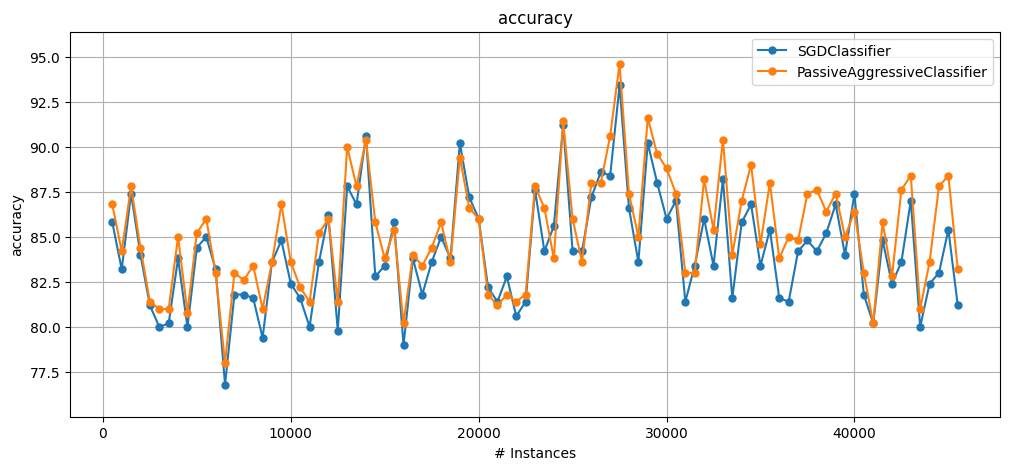

In [5]:
%%time
from capymoa.classifier import SGDClassifier, PassiveAggressiveClassifier
from capymoa.evaluation import prequential_evaluation_multiple_learners
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.datasets import Electricity

stream = Electricity()

sklearn_SGD = SGDClassifier(schema=stream.get_schema())
sklearn_PA = PassiveAggressiveClassifier(schema=stream.get_schema())

results = prequential_evaluation_multiple_learners(
    stream=stream, learners={"SGD": sklearn_SGD, "PA": sklearn_PA}, window_size=500
)

plot_windowed_results(results["SGD"], results["PA"], metric="accuracy")